In [1]:
from glob import glob
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf



Load images from folder


In [3]:
from cv2 import cvtColor


CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def augImg(img):
    flipped = cv2.flip(img, 1) # horizontal flip
    return flipped
def skew(img):
    rows, cols, ch = img.shape
    pts1 = np.float32([[50,50],[200,50],[50,200]])
    pts2 = np.float32([[10,100],[200,50],[100,250]])
    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
def load_images_from_folder(folder, augment=True):
    images, labels = [], []
    for label, className in enumerate(CLASS_NAMES):
        class_folder = os.path.join(folder, className)
        for filename in os.listdir(class_folder):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is None:
                continue
            img = cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
            if augment:
                images.append(augImg(img))
                labels.append(label)
                images.append(skew(img))
                labels.append(label)
                cropped = tf.image.central_crop(img, central_fraction=0.5).numpy()
                cropped = cv2.resize(cropped, (128, 128))
                images.append(cropped)
                labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
X_train, y_train = load_images_from_folder('intel-image-classification/seg_train/seg_train/', augment=True)
X_test, y_test = load_images_from_folder('intel-image-classification/seg_test/seg_test/', augment=False)

In [5]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(56136, 128, 128, 3) (56136,)
(3000, 128, 128, 3) (3000,)


Henter Short data

In [12]:
data_mengde = 20

# bruk kun 1 av 10 bilder
train_sel = np.arange(0, len(X_train), data_mengde)
test_sel = np.arange(0, len(X_test), data_mengde)
X_train_short = X_train[train_sel]
y_train_short = y_train[train_sel]
X_test_short = X_test[test_sel]
y_test_short = y_test[test_sel]

print("Brukte "+ str(round(100/data_mengde, 2)) +"% av dataen")
print(X_train_short.shape, y_train_short.shape)
print(X_test_short.shape, y_test_short.shape)

Brukte 5.0% av dataen
(2807, 128, 128, 3) (2807,)
(150, 128, 128, 3) (150,)


In [13]:
print(X_train_short.shape, y_train_short.shape)
print(X_test_short.shape, y_test_short.shape)

(2807, 128, 128, 3) (2807,)
(150, 128, 128, 3) (150,)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
tf.keras.utils.set_random_seed(42)


bruker 31 min 30 sek, 78,8% acc på 50% av dataen

In [15]:


X_train_img = X_train_short.astype("float32") / 255.0
X_test_img = X_test_short.astype("float32") / 255.0


cnn_model = models.Sequential(
    [
        layers.Input(shape=(128, 128, 3)),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(len(CLASS_NAMES), activation="softmax"),
    ]
)

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stop = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history = cnn_model.fit(
    X_train_img,
    y_train_short,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0,
)

test_loss, test_acc = cnn_model.evaluate(X_test_img, y_test_short, verbose=0)
print(f"CNN test accuracy: {test_acc:.4f}")


CNN test accuracy: 0.7133


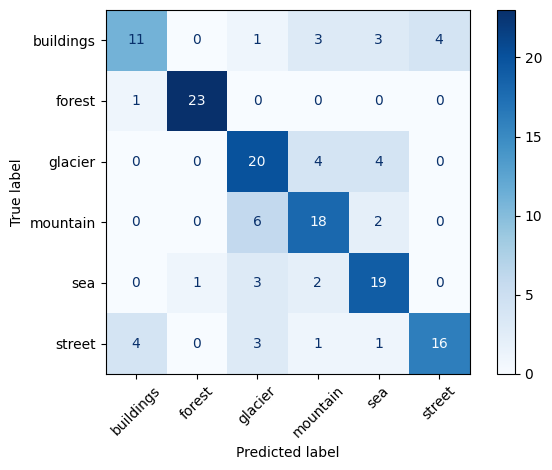

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(cnn_model.predict(X_test_img, verbose=0), axis=1)
cm = confusion_matrix(y_test_short, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.tight_layout()
plt.show()


In [18]:
def build_cnn_model(
    learning_rate=1e-3,
    dropout_rate=0.4,
    filters=(32, 64, 128),
    dense_units=256,
):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(128, 128, 3)),
            tf.keras.layers.Conv2D(filters[0], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(filters[1], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(filters[2], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(dense_units, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


In [19]:
import itertools
import numpy as np

In [28]:
X_train_img = X_train_short.astype("float32") / 255.0
X_test_img = X_test_short.astype("float32") / 255.0


learning_rates = [1e-2, 1e-3, 5e-4]  # instead of just [1e-3]

dropout_rates = [0.4]
batch_sizes = [64]
filter_options = [(32,64,128)]
dense_options = [256]

best_val_acc = -np.inf
best_params = None
best_model = None

for lr, dr, bs, fo, do in itertools.product(learning_rates, dropout_rates, batch_sizes, filter_options, dense_options):
    print(f"Tester lr={lr}, dropout={dr}, batch_size={bs}, filters={fo}, dense_units={do}")

    model = build_cnn_model(
        learning_rate=lr,
        dropout_rate=dr,
        filters=fo,
        dense_units=do,
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train_img,
        y_train_short,
        epochs=8,            #denne kan justeres, holder den kort nå under trening
        batch_size=bs,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
    )

    val_acc = max(history.history["val_accuracy"])
    print(f" -> val_accuracy={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = {"lr": lr, "dropout": dr, "batch_size": bs}
        best_model = model  # beholder best weights

print("Beste kombinasjon:", best_params, "med val_accuracy:", best_val_acc)


Tester lr=0.01, dropout=0.4, batch_size=64, filters=(32, 64, 128), dense_units=256
 -> val_accuracy=0.4662
Tester lr=0.001, dropout=0.4, batch_size=64, filters=(32, 64, 128), dense_units=256
 -> val_accuracy=0.6477
Tester lr=0.0005, dropout=0.4, batch_size=64, filters=(32, 64, 128), dense_units=256
 -> val_accuracy=0.5053
Beste kombinasjon: {'lr': 0.001, 'dropout': 0.4, 'batch_size': 64} med val_accuracy: 0.6476868391036987


In [29]:
test_loss, test_acc = best_model.evaluate(X_test_img, y_test_short, verbose=0)
print(f"Best CNN test accuracy: {test_acc:.4f}")


Best CNN test accuracy: 0.6600


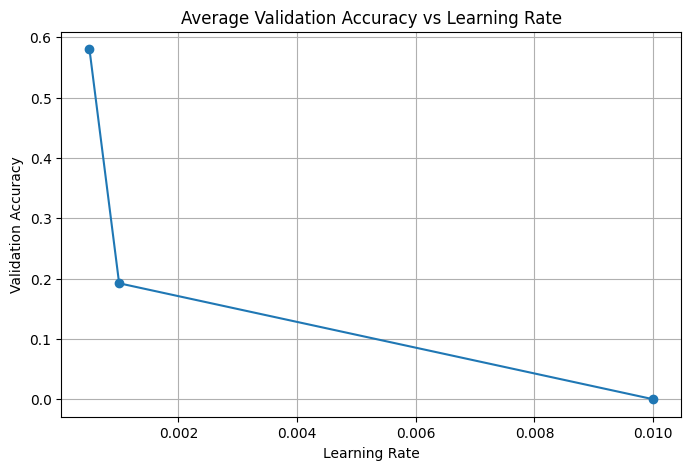

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# Suppose we store results in a list during grid search
# Each item: (val_acc, lr, dropout, batch_size, filters, dense_units)
results = []

for lr, dr, bs, fo, do in itertools.product(learning_rates, dropout_rates, batch_sizes, filter_options, dense_options):
    model = build_cnn_model(
        learning_rate=lr,
        dropout_rate=dr,
        filters=fo,
        dense_units=do,
    )
    
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True,
    )
    
    history = model.fit(
        X_train_img,
        y_train_short,
        epochs=8,
        batch_size=bs,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
    )
    
    val_acc = max(history.history["val_accuracy"])
    results.append((val_acc, lr, dr, bs, fo, do))

# Convert to DataFrame for easier plotting
df = pd.DataFrame(results, columns=["val_acc", "learning_rate", "dropout", "batch_size", "filters", "dense_units"])

# Example plot: Accuracy vs Learning Rate (averaging over other parameters)
avg_acc = df.groupby("learning_rate")["val_acc"].mean()

plt.figure(figsize=(8,5))
plt.plot(avg_acc.index, avg_acc.values, marker='o')
plt.title("Average Validation Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


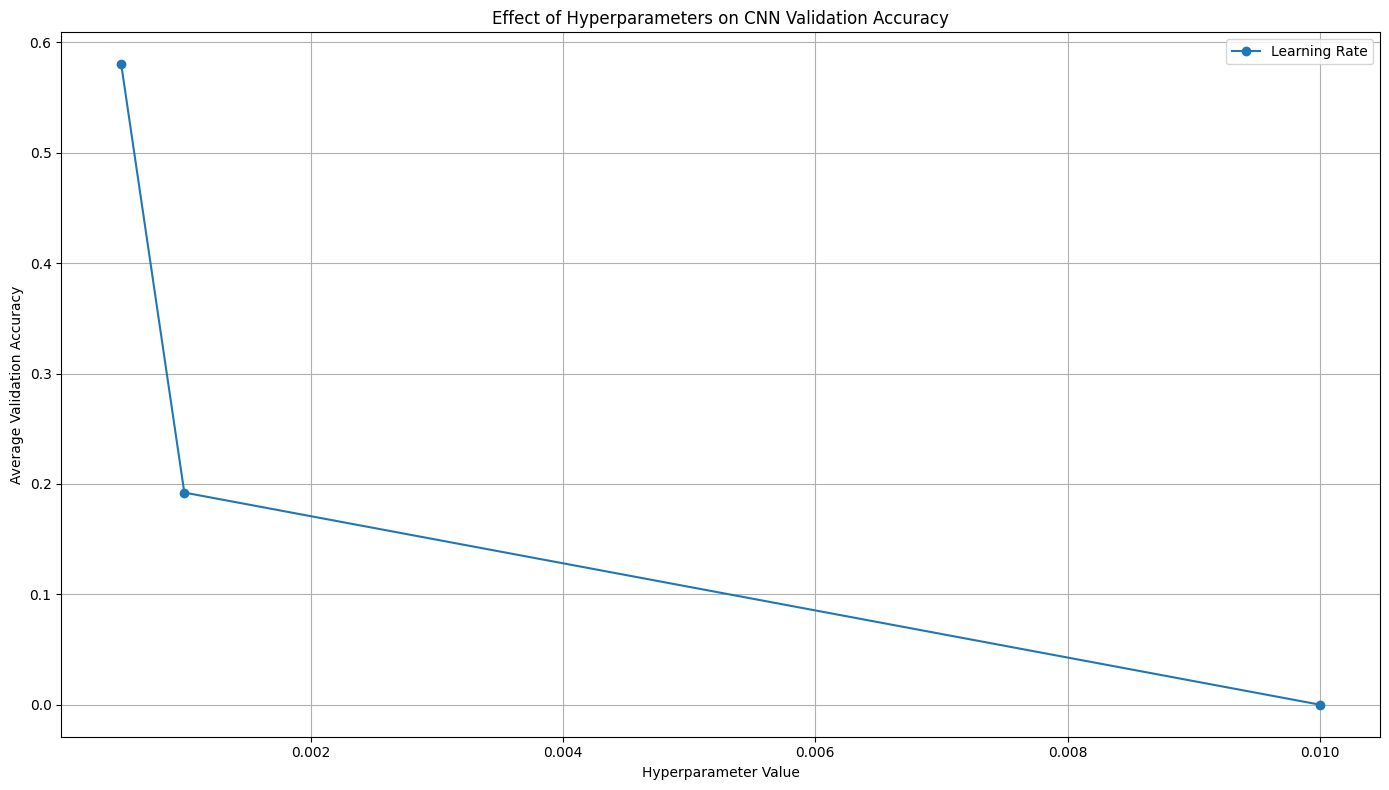

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert filter tuples to strings for easier plotting
df["filters_str"] = df["filters"].apply(lambda x: str(x))

plt.figure(figsize=(14, 8))

# 1️⃣ Learning Rate (if multiple values)
if df["learning_rate"].nunique() > 1:
    avg_lr = df.groupby("learning_rate")["val_acc"].mean()
    plt.plot(avg_lr.index, avg_lr.values, marker='o', label="Learning Rate")

# 2️⃣ Dropout Rate
if df["dropout"].nunique() > 1:
    avg_dr = df.groupby("dropout")["val_acc"].mean()
    plt.plot(avg_dr.index, avg_dr.values, marker='s', label="Dropout Rate")

# 3️⃣ Batch Size
if df["batch_size"].nunique() > 1:
    avg_bs = df.groupby("batch_size")["val_acc"].mean()
    plt.plot(avg_bs.index, avg_bs.values, marker='^', label="Batch Size")

# 4️⃣ Filters (categorical)
if df["filters_str"].nunique() > 1:
    avg_filters = df.groupby("filters_str")["val_acc"].mean()
    plt.plot(range(len(avg_filters)), avg_filters.values, marker='x', label="Filters")
    plt.xticks(range(len(avg_filters)), avg_filters.index, rotation=45)

# 5️⃣ Dense units
if df["dense_units"].nunique() > 1:
    avg_dense = df.groupby("dense_units")["val_acc"].mean()
    plt.plot(avg_dense.index, avg_dense.values, marker='d', label="Dense Units")

plt.title("Effect of Hyperparameters on CNN Validation Accuracy")
plt.xlabel("Hyperparameter Value")
plt.ylabel("Average Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


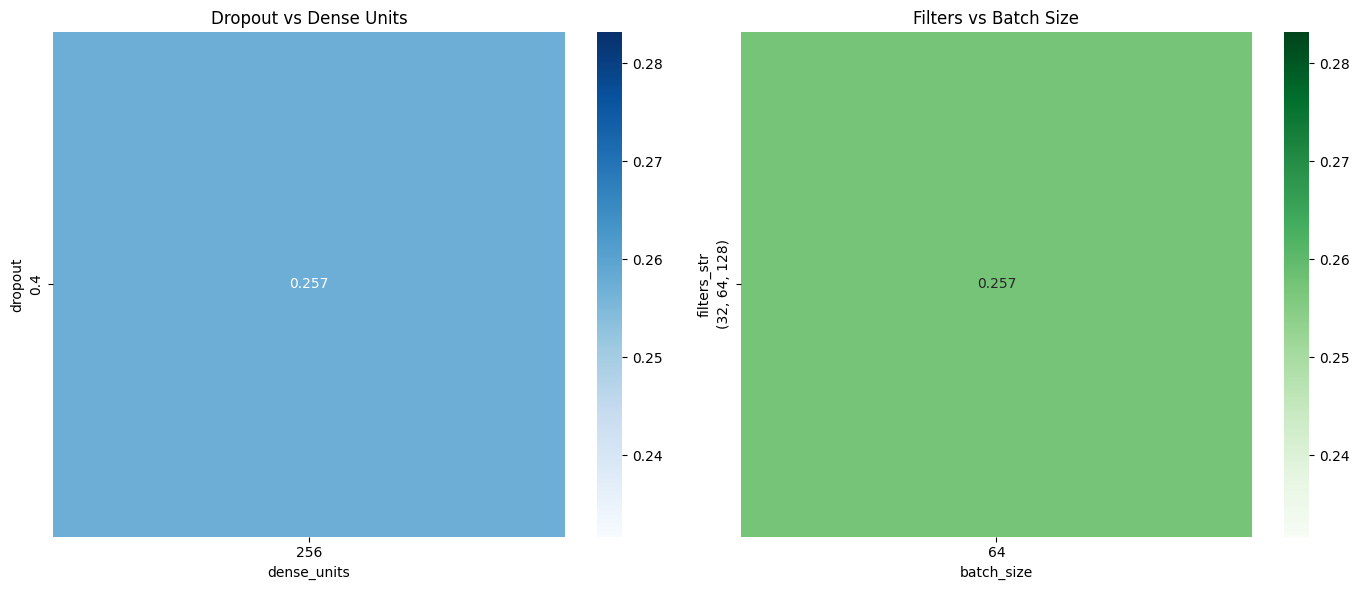

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Heatmap 1: Dropout vs Dense Units
heatmap1 = df.groupby(["dropout", "dense_units"])["val_acc"].mean().unstack()
sns.heatmap(heatmap1, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
axes[0].set_title("Dropout vs Dense Units")

# Heatmap 2: Filters vs Batch Size
heatmap2 = df.groupby(["filters_str", "batch_size"])["val_acc"].mean().unstack()
sns.heatmap(heatmap2, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
axes[1].set_title("Filters vs Batch Size")

plt.tight_layout()
plt.show()



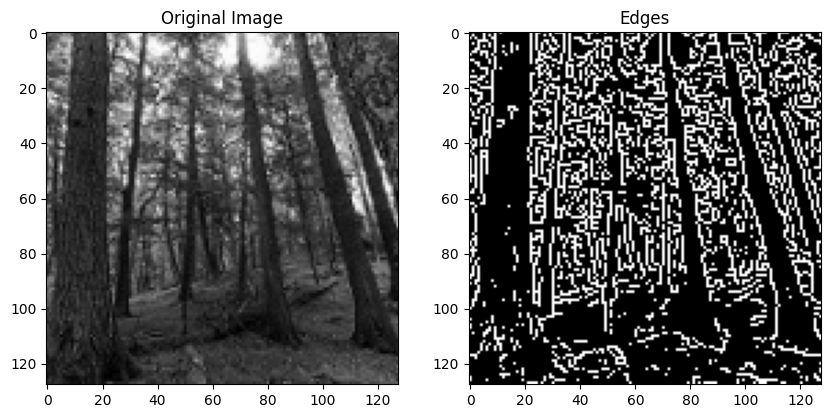

In [37]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.cvtColor(my_img, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detector
edges = cv2.Canny(image, 128, 128)

# Display the original image and the edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Edges')
plt.imshow(edges, cmap='gray')
plt.show()

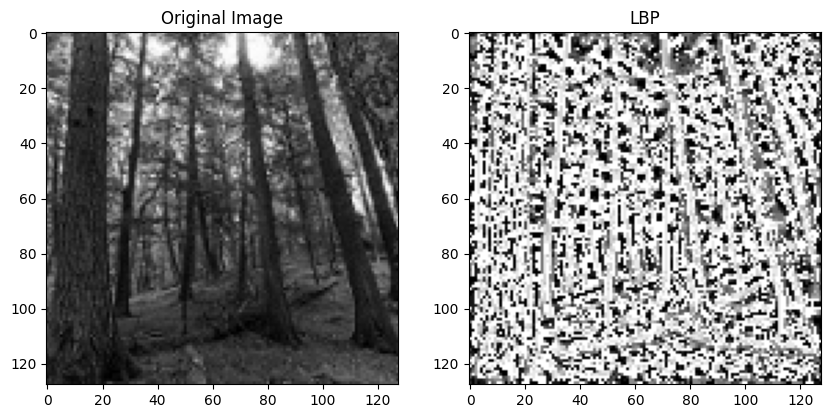

In [39]:
from skimage import io, feature
import matplotlib.pyplot as plt


# Apply Local Binary Pattern (LBP)
lbp = feature.local_binary_pattern(image, P=10, R=3, method='uniform')

# Display the original image and the LBP result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('LBP')
plt.imshow(lbp, cmap='gray')
plt.show()

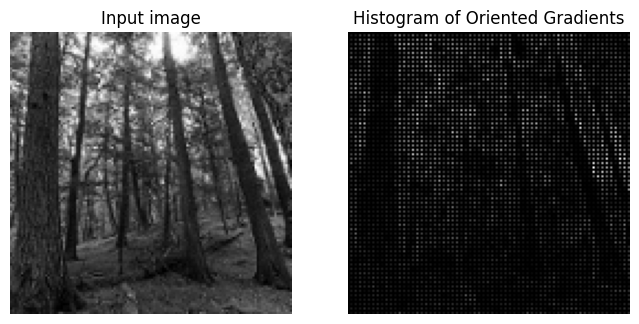

In [40]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

image = cv2.cvtColor(my_img, cv2.COLOR_RGB2GRAY)

fd, hog_image = hog(
    image,
    orientations=16,
    pixels_per_cell=(2, 2),
    cells_per_block=(8, 8),
    visualize=True,
    channel_axis=None,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image)

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [41]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm


def extract_features(batch):
    feats = []
    for img in tqdm(batch, desc="Extracting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        fd, _ = hog(
            gray,
            orientations=16,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None,
        )

        # edges = cv2.Canny(gray, 128, 128).flatten().astype(np.float32) / 255.0

        lbp = local_binary_pattern(gray, P=10, R=3, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)

        # feats.append(np.concatenate([fd, edges, lbp_hist]))
        feats.append(np.concatenate([fd, lbp_hist]))

    return np.asarray(feats, dtype=np.float32)

# X_train_feats = extract_features(X_train)
# X_test_feats = extract_features(X_test)
# y_train_feats = y_train.copy()
# y_test_feats = y_test.copy()

Extracting hog features:   0%|          | 0/2807 [00:00<?, ?it/s]

Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 205.79it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {} -> Train: 1.000, Test: 0.633


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 221.18it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {} -> Train: 1.000, Test: 0.633


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 165.73it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {} -> Train: 1.000, Test: 0.620


Extracting hog features: 100%|██████████| 150/150 [00:01<00:00, 117.79it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {} -> Train: 1.000, Test: 0.620


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 460.46it/s]


Method: lbp, HOG: {}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 0.995, Test: 0.540


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 327.29it/s]


Method: lbp, HOG: {}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 0.996, Test: 0.547


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 487.86it/s]


Method: lbp, HOG: {}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 0.995, Test: 0.540


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 301.98it/s]


Method: lbp, HOG: {}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 0.996, Test: 0.547


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 117.21it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.647


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 124.72it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.607


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 98.67it/s] 


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.600


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 90.69it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.600


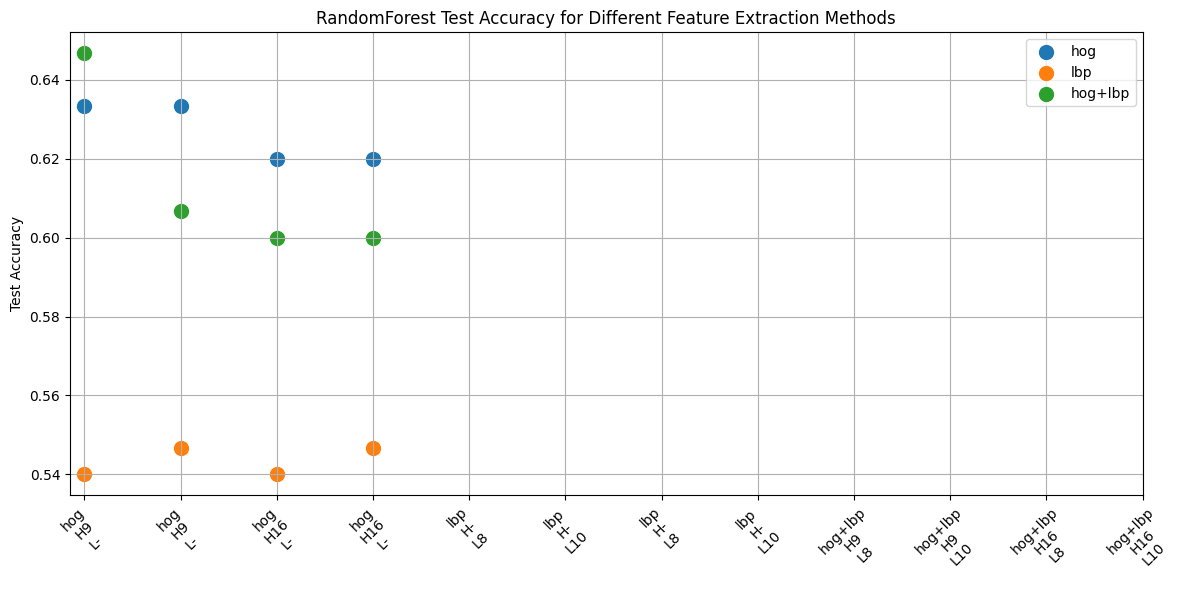

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

# -----------------------------
# Feature extraction function
# -----------------------------
def extract_features(batch, method="hog", hog_params=None, lbp_params=None):
    feats = []
    for img in tqdm(batch, desc=f"Extracting {method} features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if method == "hog":
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            feats.append(fd)
        
        elif method == "lbp":
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(lbp_hist)
        
        elif method == "hog+lbp":
            # Combine HOG + LBP
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(np.concatenate([fd, lbp_hist]))
        
        else:
            raise ValueError("Unknown feature extraction method")
    
    return np.asarray(feats, dtype=np.float32)

# -----------------------------
# Parameter grid
# -----------------------------
hog_params_list = [
    {"orientations": 9, "pixels_per_cell": (8,8), "cells_per_block": (3,3)},
    {"orientations": 16, "pixels_per_cell": (8,8), "cells_per_block": (2,2)},
]

lbp_params_list = [
    {"P": 8, "R": 1, "method": "uniform"},
    {"P": 10, "R": 3, "method": "uniform"},
]

methods = ["hog", "lbp", "hog+lbp"]

results = []

# -----------------------------
# Sweep all combinations
# -----------------------------
for method in methods:
    for hp, lp in itertools.product(hog_params_list, lbp_params_list):
        # Only use relevant params for the method
        hp_use = hp if "hog" in method else {}
        lp_use = lp if "lbp" in method else {}
        
        # Extract features
        X_train_feats = extract_features(X_train_short, method=method, hog_params=hp_use, lbp_params=lp_use)
        X_test_feats = extract_features(X_test_short, method=method, hog_params=hp_use, lbp_params=lp_use)
        
        # Train RandomForest
        clf = RandomForestClassifier(random_state=42, n_estimators=300, min_samples_split=5)
        clf.fit(X_train_feats, y_train_short)
        
        # Evaluate
        train_acc = accuracy_score(y_train_short, clf.predict(X_train_feats))
        test_acc = accuracy_score(y_test_short, clf.predict(X_test_feats))
        
        results.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "train_acc": train_acc,
            "test_acc": test_acc
        })
        print(f"Method: {method}, HOG: {hp_use}, LBP: {lp_use} -> Train: {train_acc:.3f}, Test: {test_acc:.3f}")

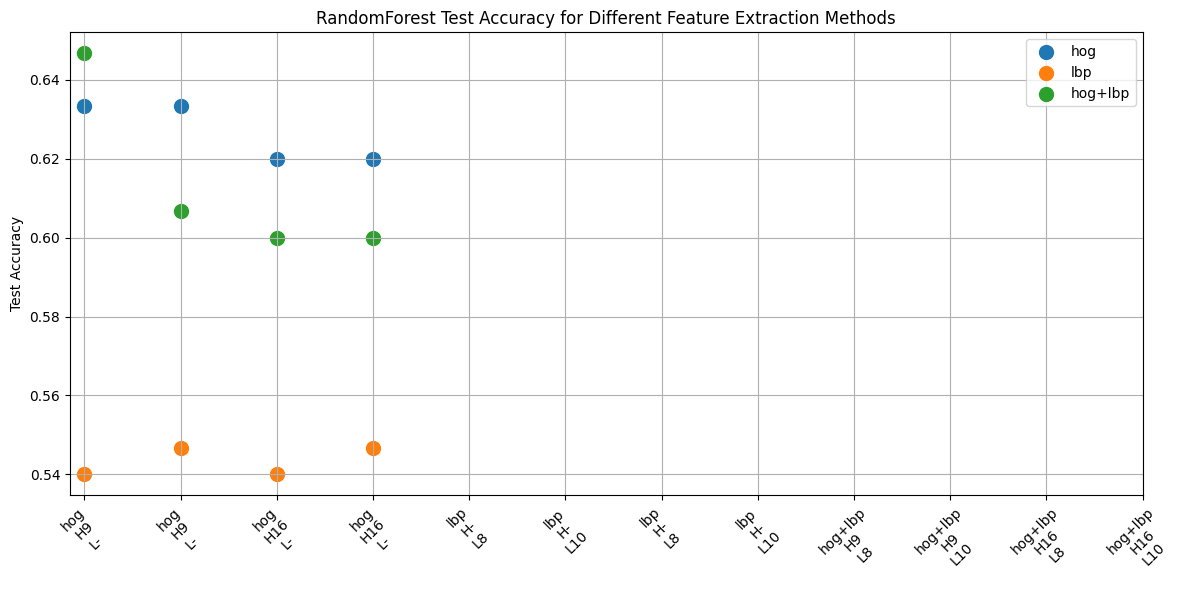

In [47]:
# -----------------------------
# Plot comparison
# -----------------------------
import pandas as pd

df_results = pd.DataFrame(results)

plt.figure(figsize=(12,6))
for method in methods:
    subset = df_results[df_results["method"]==method]
    plt.scatter(range(len(subset)), subset["test_acc"], label=method, s=100)
plt.xticks(range(len(df_results)), [f"{r['method']}\nH{r['hog_params']['orientations'] if r['hog_params'] else '-'}\nL{r['lbp_params']['P'] if r['lbp_params'] else '-'}" for r in results], rotation=45)
plt.ylabel("Test Accuracy")
plt.title("RandomForest Test Accuracy for Different Feature Extraction Methods")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 213.41it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {} -> Train: 1.000, Test: 0.633


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 213.57it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {} -> Train: 1.000, Test: 0.633


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 178.93it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {} -> Train: 1.000, Test: 0.620


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 151.46it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {} -> Train: 1.000, Test: 0.620


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 421.80it/s]


Method: lbp, HOG: {}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 0.995, Test: 0.540


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 370.30it/s]


Method: lbp, HOG: {}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 0.996, Test: 0.547


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 333.42it/s]


Method: lbp, HOG: {}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 0.995, Test: 0.540


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 305.28it/s]


Method: lbp, HOG: {}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 0.996, Test: 0.547


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 137.03it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.647


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 107.84it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.607


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 113.79it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.600


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 112.22it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.600


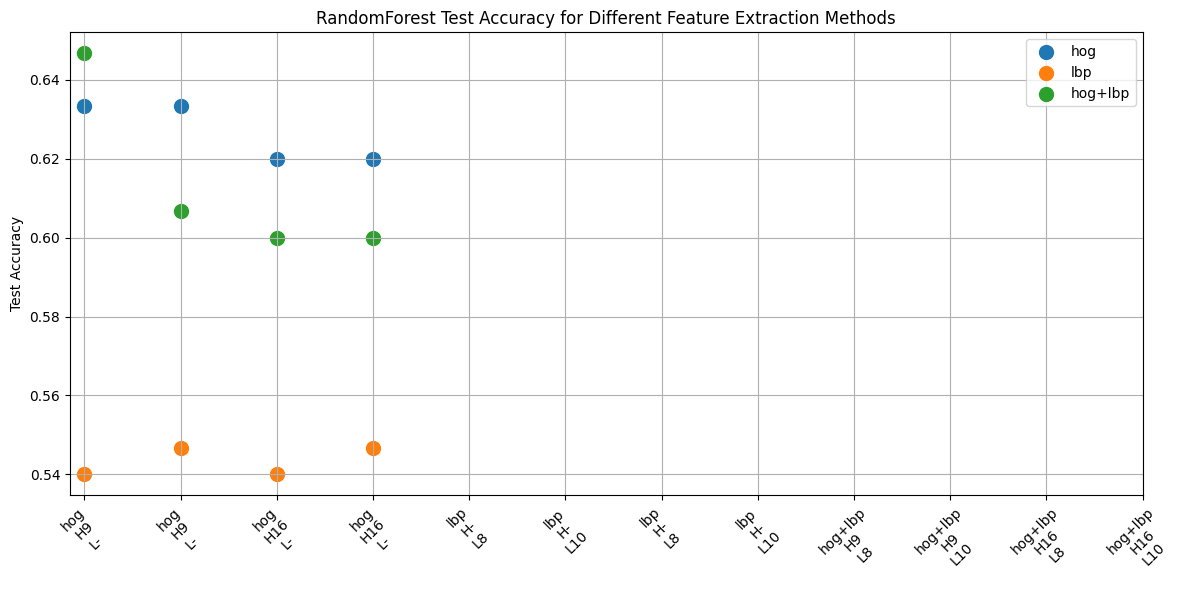

In [48]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# Feature extraction function
# -----------------------------
def extract_features(batch, method="hog", hog_params=None, lbp_params=None):
    feats = []
    for img in tqdm(batch, desc=f"Extracting {method} features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if method == "hog":
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            feats.append(fd)
        
        elif method == "lbp":
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(lbp_hist)
        
        elif method == "hog+lbp":
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(np.concatenate([fd, lbp_hist]))
        
        else:
            raise ValueError("Unknown feature extraction method")
    
    return np.asarray(feats, dtype=np.float32)

# -----------------------------
# Parameter grid
# -----------------------------
hog_params_list = [
    {"orientations": 9, "pixels_per_cell": (8,8), "cells_per_block": (3,3)},
    {"orientations": 16, "pixels_per_cell": (8,8), "cells_per_block": (2,2)},
]

lbp_params_list = [
    {"P": 8, "R": 1, "method": "uniform"},
    {"P": 10, "R": 3, "method": "uniform"},
]

methods = ["hog", "lbp", "hog+lbp"]

results = []

# -----------------------------
# Sweep all combinations
# -----------------------------
for method in methods:
    for hp, lp in itertools.product(hog_params_list, lbp_params_list):
        # Only use relevant params for the method
        hp_use = hp if "hog" in method else {}
        lp_use = lp if "lbp" in method else {}
        
        # Extract features
        X_train_feats = extract_features(X_train_short, method=method, hog_params=hp_use, lbp_params=lp_use)
        X_test_feats = extract_features(X_test_short, method=method, hog_params=hp_use, lbp_params=lp_use)
        
        # Train RandomForest
        clf = RandomForestClassifier(random_state=42, n_estimators=300, min_samples_split=5)
        clf.fit(X_train_feats, y_train_short)
        
        # Evaluate
        train_acc = accuracy_score(y_train_short, clf.predict(X_train_feats))
        test_acc = accuracy_score(y_test_short, clf.predict(X_test_feats))
        
        results.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "train_acc": train_acc,
            "test_acc": test_acc
        })
        print(f"Method: {method}, HOG: {hp_use}, LBP: {lp_use} -> Train: {train_acc:.3f}, Test: {test_acc:.3f}")

# -----------------------------
# Plot comparison
# -----------------------------
df_results = pd.DataFrame(results)

plt.figure(figsize=(12,6))
for method in methods:
    subset = df_results[df_results["method"]==method]
    plt.scatter(range(len(subset)), subset["test_acc"], label=method, s=100)

# Set x-ticks to show parameters
xticks_labels = [
    f"{r['method']}\nH{r['hog_params'].get('orientations','-')}\nL{r['lbp_params'].get('P','-')}"
    for r in results
]
plt.xticks(range(len(df_results)), xticks_labels, rotation=45)
plt.ylabel("Test Accuracy")
plt.title("RandomForest Test Accuracy for Different Feature Extraction Methods")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Bruker ca 6 min

In [ ]:


clf = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=300, min_samples_split=5)


clf.fit(X_train_feats, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train_feats)))
print("Test accuracy: ", accuracy_score(y_test, clf.predict(X_test_feats)))






Training accuracy:  0.9992874447769702
Test accuracy:  0.6706666666666666


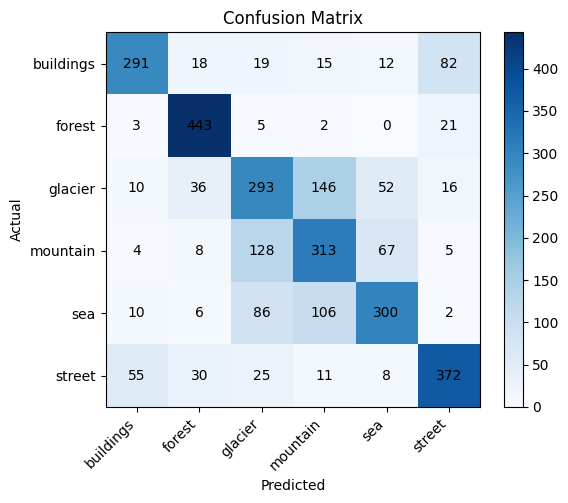

0.6706666666666666


In [ ]:
y_pred = clf.predict(X_test_feats)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks(range(len(CLASS_NAMES)))
ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()
print(accuracy_score(y_test, y_pred))

In [ ]:
print(accuracy_score(y_test, y_pred))

0.6706666666666666



--- Testing feature model: HOG ---


Extracting hog features: 100%|██████████| 100/100 [00:00<00:00, 188.39it/s]


[Trees=5] -> TestAcc: 1.000
[Trees=10] -> TestAcc: 1.000
[Trees=20] -> TestAcc: 1.000

--- Testing feature model: LBP ---


Extracting lbp features: 100%|██████████| 100/100 [00:00<00:00, 975.39it/s]


[Trees=5] -> TestAcc: 1.000
[Trees=10] -> TestAcc: 1.000
[Trees=20] -> TestAcc: 1.000

--- Testing feature model: Canny ---


Extracting canny features: 100%|██████████| 100/100 [00:00<00:00, 2655.01it/s]


[Trees=5] -> TestAcc: 1.000
[Trees=10] -> TestAcc: 1.000
[Trees=20] -> TestAcc: 1.000

--- Testing feature model: HOG+LBP ---


Extracting hog+lbp features: 100%|██████████| 100/100 [00:00<00:00, 177.60it/s]


[Trees=5] -> TestAcc: 1.000
[Trees=10] -> TestAcc: 1.000
[Trees=20] -> TestAcc: 1.000

--- Testing feature model: HOG+LBP+Canny ---


Extracting hog+lbp+canny features: 100%|██████████| 100/100 [00:00<00:00, 140.94it/s]


[Trees=5] -> TestAcc: 1.000
[Trees=10] -> TestAcc: 1.000
[Trees=20] -> TestAcc: 1.000


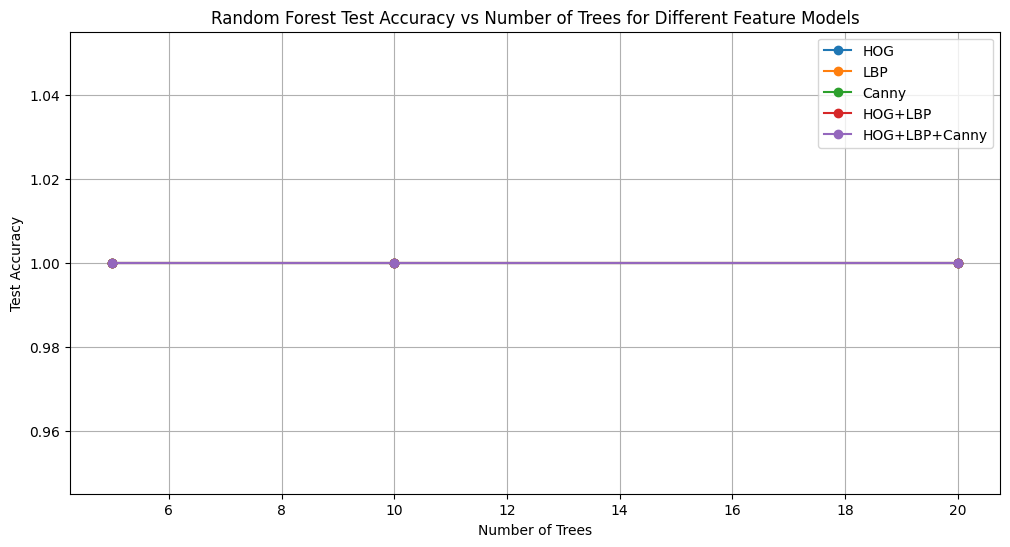

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd

# ---- Small subset for fast demo ----
N_TRAIN = 200
N_TEST = 100

X_train_small = X_train[:N_TRAIN]
y_train_small = y_train[:N_TRAIN]
X_test_small = X_test[:N_TEST]
y_test_small = y_test[:N_TEST]

# ---- Feature extraction functions ----
def feat_hog(img, orientations=4, pixels=(16,16), cells=(1,1)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd, _ = hog(gray, orientations=orientations, pixels_per_cell=pixels, cells_per_block=cells, visualize=True, channel_axis=None)
    return fd

def feat_lbp(img, P=4, R=1):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P=P, R=R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max()+2), density=True)
    return hist

def feat_canny(img, low=50, high=150):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, low, high).flatten().astype(np.float32)/255.0
    return edges

def extract_features_batch(batch, feature_type='hog', params={}):
    feats = []
    for img in tqdm(batch, desc=f"Extracting {feature_type} features"):
        if feature_type=='hog':
            feats.append(feat_hog(img, **params))
        elif feature_type=='lbp':
            feats.append(feat_lbp(img, **params))
        elif feature_type=='canny':
            feats.append(feat_canny(img, **params))
        elif feature_type=='hog+lbp':
            feats.append(np.concatenate([feat_hog(img, **params.get('hog',{})), feat_lbp(img, **params.get('lbp',{}))]))
        elif feature_type=='hog+lbp+canny':
            feats.append(np.concatenate([
                feat_hog(img, **params.get('hog',{})),
                feat_lbp(img, **params.get('lbp',{})),
                feat_canny(img, **params.get('canny',{}))
            ]))
    return np.array(feats, dtype=np.float32)

# ---- Feature methods to test ----
feature_models = {
    'HOG': {'hog': {'orientations':4, 'pixels':(16,16), 'cells':(1,1)}},
    'LBP': {'lbp': {'P':4, 'R':1}},
    'Canny': {'canny': {'low':50, 'high':150}},
    'HOG+LBP': {'hog+lbp': {'hog':{'orientations':4, 'pixels':(16,16), 'cells':(1,1)}, 'lbp':{'P':4,'R':1}}},
    'HOG+LBP+Canny': {'hog+lbp+canny': {'hog':{'orientations':4, 'pixels':(16,16), 'cells':(1,1)}, 'lbp':{'P':4,'R':1}, 'canny':{'low':50,'high':150}}}
}

rf_trees_list = [5, 10, 20]

results = []

# ---- Loop over feature models ----
for feat_name, params in feature_models.items():
    print(f"\n--- Testing feature model: {feat_name} ---")
    
    Xtr = extract_features_batch(X_train_small, feature_type=feat_name.lower(), params=params.get(feat_name.lower(),{}))
    Xte = extract_features_batch(X_test_small, feature_type=feat_name.lower(), params=params.get(feat_name.lower(),{}))
    
    for n_tree in rf_trees_list:
        clf = RandomForestClassifier(n_estimators=n_tree, random_state=42, min_samples_split=3)
        clf.fit(Xtr, y_train_small)
        acc = accuracy_score(y_test_small, clf.predict(Xte))
        
        results.append({
            'FeatureModel': feat_name,
            'Trees': n_tree,
            'TestAcc': acc
        })
        print(f"[Trees={n_tree}] -> TestAcc: {acc:.3f}")

df = pd.DataFrame(results)

# ---- Plot results ----
plt.figure(figsize=(12,6))
for feat_name in feature_models.keys():
    subset = df[df['FeatureModel']==feat_name]
    plt.plot(subset['Trees'], subset['TestAcc'], marker='o', label=feat_name)

plt.title("Random Forest Test Accuracy vs Number of Trees for Different Feature Models")
plt.xlabel("Number of Trees")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
### SLOW : approx 30 min
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot effect of HOG orientations
for lbpP in lbp_P_list:
    avg = df[df["lbp_P"] == lbpP].groupby("hog_orient")["test_acc"].mean()
    ax[0].plot(avg.index, avg.values, marker='o', label=f"LBP_P={lbpP}")

ax[0].set_title("Test Accuracy vs HOG Orientations")
ax[0].set_xlabel("HOG orientations")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Effect of LBP P parameter
for hog_orient in hog_orientations_list:
    avg = df[df["hog_orient"] == hog_orient].groupby("lbp_P")["test_acc"].mean()
    ax[1].plot(avg.index, avg.values, marker='o', label=f"HOG={hog_orient}")

ax[1].set_title("Test Accuracy vs LBP P")
ax[1].set_xlabel("LBP P value")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

# Effect of RandomForest trees
avg = df.groupby("n_estimators")["test_acc"].mean()
ax[2].plot(avg.index, avg.values, marker='o')
ax[2].set_title("Test Accuracy vs RandomForest n_estimators")
ax[2].set_xlabel("Number of Trees")
ax[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot effect of HOG orientations
for lbpP in lbp_P_list:
    avg = df[df["lbp_P"] == lbpP].groupby("hog_orient")["test_acc"].mean()
    ax[0].plot(avg.index, avg.values, marker='o', label=f"LBP_P={lbpP}")

ax[0].set_title("Test Accuracy vs HOG Orientations")
ax[0].set_xlabel("HOG orientations")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Effect of LBP P parameter
for hog_orient in hog_orientations_list:
    avg = df[df["hog_orient"] == hog_orient].groupby("lbp_P")["test_acc"].mean()
    ax[1].plot(avg.index, avg.values, marker='o', label=f"HOG={hog_orient}")

ax[1].set_title("Test Accuracy vs LBP P")
ax[1].set_xlabel("LBP P value")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

# Effect of RandomForest trees
avg = df.groupby("n_estimators")["test_acc"].mean()
ax[2].plot(avg.index, avg.values, marker='o')
ax[2].set_title("Test Accuracy vs RandomForest n_estimators")
ax[2].set_xlabel("Number of Trees")
ax[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


XGBoost

In [ ]:
# ...existing code...
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=len(CLASS_NAMES),
    max_depth=8,
    n_estimators=400,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
)
xgb_clf.fit(X_train_feats, y_train_feats)

xgb_pred = xgb_clf.predict(X_test_feats)
print(classification_report(y_test_feats, xgb_pred, target_names=CLASS_NAMES))
print(confusion_matrix(y_test_feats, xgb_pred))
print("XGB accuracy:", accuracy_score(y_test_feats, xgb_pred))

KeyboardInterrupt: 

generere short data

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm


def extract_features(batch):
    feats = []
    for img in tqdm(batch, desc="Extracting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        fd, _ = hog(
            gray,
            orientations=16,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None,
        )

        # edges = cv2.Canny(gray, 128, 128).flatten().astype(np.float32) / 255.0

        lbp = local_binary_pattern(gray, P=10, R=3, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)

        # feats.append(np.concatenate([fd, edges, lbp_hist]))
        feats.append(np.concatenate([fd, lbp_hist]))

    return np.asarray(feats, dtype=np.float32)

X_train_short_feats = extract_features(X_train_short)
X_test_short_feats = extract_features(X_test_short)
y_train_short_feats = y_train_short.copy()
y_test_short_feats = y_test_short.copy()

Extracting features:   0%|          | 0/2807 [00:00<?, ?it/s]

Extracting features: 100%|██████████| 600/600 [00:47<00:00, 12.67it/s]


In [ ]:
clf_short = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=300, min_samples_split=5)


clf_short.fit(X_train_short_feats, y_train_short)
print("Training accuracy: ", accuracy_score(y_train_short, clf_short.predict(X_train_short_feats)))
print("Test accuracy: ", accuracy_score(y_test_short, clf_short.predict(X_test_short_feats)))

Training accuracy:  1.0
Test accuracy:  0.625


XGBoost på short_data

In [ ]:
# ...existing code...
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=len(CLASS_NAMES),
    max_depth=8,
    n_estimators=400,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
)
xgb_clf.fit(X_train_short_feats, y_train_short)

xgb_pred = xgb_clf.predict(X_test_short_feats)
print(classification_report(y_test_short, xgb_pred, target_names=CLASS_NAMES))
print(confusion_matrix(y_test_short, xgb_pred))
print("XGB accuracy:", accuracy_score(y_test_short, xgb_pred))

              precision    recall  f1-score   support

   buildings       0.81      0.68      0.74        88
      forest       0.81      0.93      0.86        95
     glacier       0.55      0.57      0.56       110
    mountain       0.54      0.57      0.55       105
         sea       0.68      0.63      0.65       102
      street       0.76      0.74      0.75       100

    accuracy                           0.68       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.68      0.68      0.68       600

[[60  0  6  4  2 16]
 [ 0 88  4  0  0  3]
 [ 3  9 63 23 10  2]
 [ 2  2 26 60 14  1]
 [ 1  1 11 24 64  1]
 [ 8  9  4  1  4 74]]
XGB accuracy: 0.6816666666666666


In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import LinearSVC



svm = LinearSVC(C=1, max_iter=10000)
svm.fit(X_train_short_feats, y_train_short)

y_pred = svm.predict(X_test_short_feats)
print("LinearSVC test accuracy:", accuracy_score(y_test_short, y_pred))

LinearSVC test accuracy: 0.6166666666666667


In [ ]:
from sklearn.model_selection import StratifiedKFold

STACKING

In [ ]:


# def Stacking(model,train,y,test,n_fold):
#  folds=StratifiedKFold(n_splits=n_fold)
#  test_pred=np.empty((test.shape[0],1),float)
#  train_pred=np.empty((0,1),float)
#  for train_indices,val_indices in folds.split(train,y.values):
#     x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
#     y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
#     model.fit(X=x_train,y=y_train)
#     train_pred=np.append(train_pred,model.predict(x_val))
#     test_pred=np.append(test_pred,model.predict(test))
#  return test_pred.reshape(-1,1),train_pred

Model 1 for stacking basert på random forest short

In [ ]:
# X_train_short_df = pd.DataFrame(X_train_short_feats)
# X_test_short_df = pd.DataFrame(X_test_short_feats)
# y_train_short_s = pd.Series(y_train_short)
# y_test_short_s = pd.Series(y_test_short)

In [ ]:


# test_pred1 ,train_pred1= Stacking(model=clf_short,n_fold=5, train=X_train_short_df,test=X_test_short_df,y=y_train_short_s)

In [ ]:
# train_pred1=pd.DataFrame(train_pred1)
# test_pred1=pd.DataFrame(test_pred1)


In [ ]:
# test_pred1.head

<bound method NDFrame.head of                   0
0      0.000000e+00
1     6.952446e-310
2     1.169947e-320
3               NaN
4     6.952446e-310
...             ...
1795   5.000000e+00
1796   0.000000e+00
1797   5.000000e+00
1798   5.000000e+00
1799   5.000000e+00

[1800 rows x 1 columns]>

In [ ]:
# train_pred1.head

<bound method NDFrame.head of         0
0     4.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1399  1.0
1400  5.0
1401  1.0
1402  5.0
1403  5.0

[1404 rows x 1 columns]>

Model 2 for stacking basert på svm short

In [ ]:
# test_pred2 ,train_pred2= Stacking(model=svm,n_fold=5,train=X_train_short_df,test=X_test_short_feats,y=y_train_short_s)


In [ ]:
# train_pred2=pd.DataFrame(train_pred2)
# test_pred2=pd.DataFrame(test_pred2)

In [ ]:
# test_pred2.head

<bound method NDFrame.head of                   0
0     2.470328e-323
1      0.000000e+00
2     2.470328e-323
3     1.976263e-323
4      0.000000e+00
...             ...
1795   5.000000e+00
1796   0.000000e+00
1797   5.000000e+00
1798   5.000000e+00
1799   5.000000e+00

[1800 rows x 1 columns]>

In [ ]:
# train_pred2.head

<bound method NDFrame.head of         0
0     4.0
1     5.0
2     5.0
3     0.0
4     0.0
...   ...
1399  1.0
1400  5.0
1401  5.0
1402  5.0
1403  5.0

[1404 rows x 1 columns]>

In [ ]:
# y_train_short_s.head

<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
1399    5
1400    5
1401    5
1402    5
1403    5
Length: 1404, dtype: int64>

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
# df = pd.concat([train_pred1, train_pred2], axis=1)
# df_test = pd.concat([test_pred1, test_pred2], axis=1)

In [ ]:
# df_test.head

<bound method NDFrame.head of                   0              0
0      0.000000e+00  2.470328e-323
1     6.952446e-310   0.000000e+00
2     1.169947e-320  2.470328e-323
3               NaN  1.976263e-323
4     6.952446e-310   0.000000e+00
...             ...            ...
1795   5.000000e+00   5.000000e+00
1796   0.000000e+00   0.000000e+00
1797   5.000000e+00   5.000000e+00
1798   5.000000e+00   5.000000e+00
1799   5.000000e+00   5.000000e+00

[1800 rows x 2 columns]>

In [ ]:
# print(df.head)
# print("----")
# y_test_short_s.head

<bound method NDFrame.head of         0    0
0     4.0  4.0
1     0.0  5.0
2     0.0  5.0
3     0.0  0.0
4     0.0  0.0
...   ...  ...
1399  1.0  1.0
1400  5.0  5.0
1401  1.0  5.0
1402  5.0  5.0
1403  5.0  5.0

[1404 rows x 2 columns]>
----


<bound method NDFrame.head of 0      0
1      0
2      0
3      0
4      0
      ..
295    5
296    5
297    5
298    5
299    5
Length: 300, dtype: int64>

In [ ]:
# model = LogisticRegression(random_state=42, max_iter=1000)
# model.fit(df,y_train_short_s)
# model.score(df_test, y_test_short_s)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Bedre stacking :)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
rf_base = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    n_estimators=300,
    min_samples_split=5,
)

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
svm_base = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(C=1, max_iter=10000)),
    ]
)

In [ ]:

meta_model = LogisticRegression(random_state=42, max_iter=2000)

stacking_clf = StackingClassifier(
    estimators=[("rf", rf_base), ("svm", svm_base)],
    final_estimator=meta_model,
    stack_method="auto",
    passthrough=False,
    cv=5,
    n_jobs=-1,
)

stacking_clf.fit(X_train_short_feats, y_train_short)
stack_pred = stacking_clf.predict(X_test_short_feats)

print("Stacking train accuracy:", stacking_clf.score(X_train_short_feats, y_train_short))
print("Stacking test accuracy :", accuracy_score(y_test_short, stack_pred))
print(classification_report(y_test_short, stack_pred, target_names=CLASS_NAMES))

Stacking train accuracy: 1.0
Stacking test accuracy : 0.6566666666666666
              precision    recall  f1-score   support

   buildings       0.80      0.69      0.74        88
      forest       0.84      0.89      0.87        95
     glacier       0.50      0.56      0.53       110
    mountain       0.52      0.56      0.54       105
         sea       0.66      0.53      0.59       102
      street       0.70      0.73      0.72       100

    accuracy                           0.66       600
   macro avg       0.67      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600

